# Import Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os


try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()
    
parent_dir = os.path.join(current_dir, '..')
sys.path.insert(0, parent_dir)
    
    
from analysis_scripts.cfg import CFG

In [2]:
data_oc_df = pd.read_csv('/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Data/analysed_signal.csv')
data_mb_df = pd.read_csv('/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Data/analysed_background.csv')

In [3]:
data_oc_df = data_oc_df.drop(['n_event'], axis=1)

mass_mask = (data_oc_df['mass_Lc'] > CFG.mass_interval[0]) \
            & ( data_oc_df['mass_Lc'] < CFG.mass_interval[1]) \
            & (data_oc_df['true_decay'] == 1)
            
data_oc_df = data_oc_df[mass_mask]
data_oc_df['tag'] = 'Sig'

data_mb_df = data_mb_df.drop(['n_event'], axis=1)

mass_mask = (data_mb_df['mass_Lc'] > CFG.mass_interval[0]) & ( data_mb_df['mass_Lc'] < CFG.mass_interval[1])

data_mb_df = data_mb_df[mass_mask]
data_mb_df['tag'] = 'Bg'

raw_df = pd.concat([data_oc_df, data_mb_df], axis=0).reset_index(drop=True)

raw_df['cosAngle_r_Lc_momentum_Lc_xy'] = raw_df['cosAngle_r_Lc_momentum_Lc_xy'].apply(np.cos)
raw_df['cosAngle_r_Lc_sum_momentum_xy'] = raw_df['cosAngle_r_Lc_sum_momentum_xy'].apply(np.cos)
raw_df['cosAngle_momentum_Lc_sum_momentum_xy'] = raw_df['cosAngle_momentum_Lc_sum_momentum_xy'].apply(np.cos)

raw_df['cosAngle_r_Lc_momentum_Lc_xy_left'] = raw_df.loc[raw_df['cosAngle_r_Lc_momentum_Lc_xy'] < 0, 'cosAngle_r_Lc_momentum_Lc_xy']
raw_df['cosAngle_r_Lc_momentum_Lc_xy_right'] = raw_df.loc[raw_df['cosAngle_r_Lc_momentum_Lc_xy'] > 0, 'cosAngle_r_Lc_momentum_Lc_xy']

raw_df['cosAngle_r_Lc_sum_momentum_xy_left'] = raw_df.loc[raw_df['cosAngle_r_Lc_sum_momentum_xy'] < 0, 'cosAngle_r_Lc_sum_momentum_xy']
raw_df['cosAngle_r_Lc_sum_momentum_xy_right'] = raw_df.loc[raw_df['cosAngle_r_Lc_sum_momentum_xy'] > 0, 'cosAngle_r_Lc_sum_momentum_xy']

raw_df['l_over_dl_XY'] = raw_df['lengthXY_Lc'] / raw_df['dlengthXY_Lc']

* Perform selection in the mass range of 8.7 $\sigma$.
* Convert cosAngle to actual cos.
* Add left and right components to some variables to treat them separately.
* Add l over dl in xy plane.

# Raw Data Stats

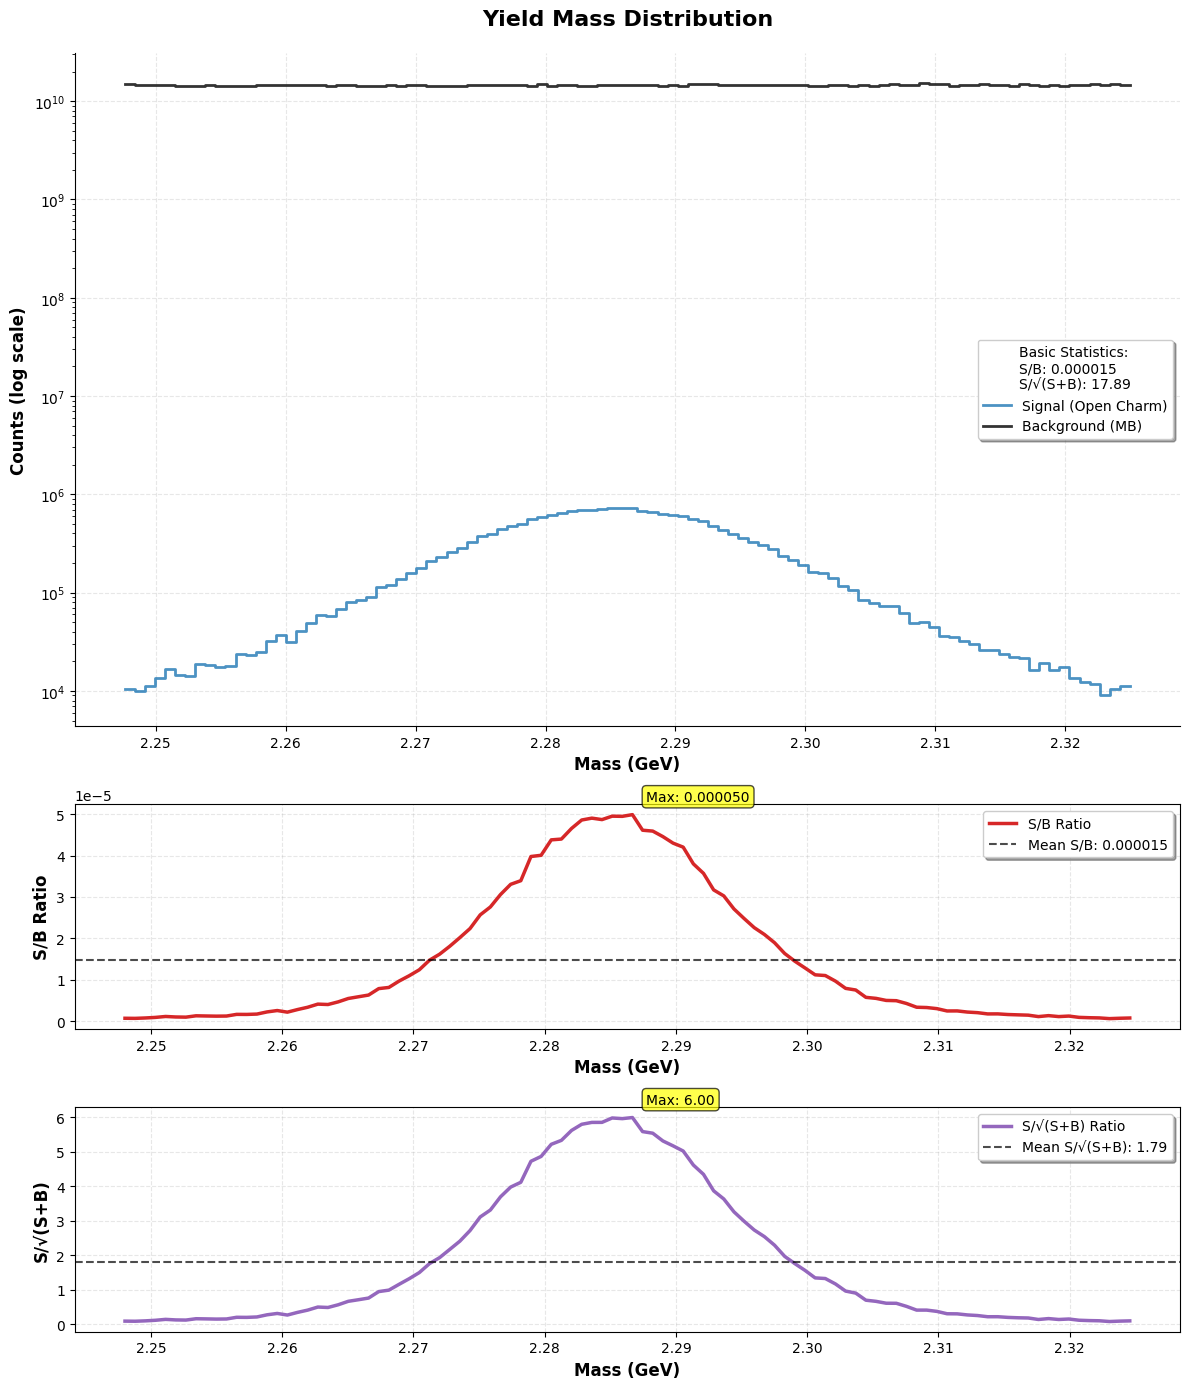


SUMMARY STATISTICS
Total Signal Events: 21553757
Total Background Events: 1451590520598
Total Signal Events Unscaled: 102593
Total Background Events Unscaled: 469260
Overall S/B Ratio: 0.000015
Overall S/sqrt(S+B) Significance: 17.89
Maximum S/B Ratio: 0.000050 at 2.287 GeV
Maximum S/sqrt(S+B): 6.00 at 2.287 GeV


In [4]:
from analysis_scripts.estimate_scripts import signal_estimates


sig_mass_distr = raw_df.loc[raw_df['tag'] == 'Sig', 'mass_Lc']
bg_mass_distr = raw_df.loc[raw_df['tag'] == 'Bg', 'mass_Lc']

_ = signal_estimates(
    sig_mass_distr=sig_mass_distr, 
    bg_mass_distr=bg_mass_distr, 
    have_sig_events=CFG.have_sig_events, 
    have_bg_events=CFG.have_bg_events,
    mass_interval=CFG.mass_interval, 
    visualization=True
)

# Preselect Data

1. Preselection performs simple quantile-based selection. It cuts off all events that lie outside the quantile_left and quantile_right quantiles based on the signal distribution. The selection process begins if there are any signal events outside the interval:
(mean - safety_interval × indent; mean + safety_interval × indent).

2. Select only cases where the number of tracks selected for PV reconstruction is greater than min_tracks_after_refit.

In [28]:
from analysis_scripts.selection_scripts import auto_preselection


proc_df = raw_df.copy()

min_tracks_after_re_fit = 7

proc_df = proc_df[proc_df['kf_pv_size_after_re_fit'] > min_tracks_after_re_fit]

features_to_select = [
    'P_p', 'P_pip', 'P_K', 'P_Lc', 'eta_p', 'eta_pip',
       'eta_K', 'eta_Lc', 'Pt_Lc', 'Pt_p', 'Pt_K', 'Pt_pip', 'lengthXY_Lc',
       'dlengthXY_Lc', 'ctau_Lc', 'OA_p', 'OA_K', 'OA_pip', 'ptOverE',
       'chi2_Lc_PV_xy', 'dist_Lc_PV_xy', 'dist_Lc_PV_xy_custom',
       'chi2_p_PV_xy', 'dist_p_PV_xy', 'dist_p_PV_xy_custom', 'chi2_K_PV_xy',
       'dist_K_PV_xy', 'dist_K_PV_xy_custom', 'chi2_pip_PV_xy',
       'dist_pip_PV_xy', 'dist_pip_PV_xy_custom', 'chi2_p_Lc_xy',
       'dist_p_Lc_xy', 'dist_p_Lc_xy_custom', 'chi2_K_Lc_xy', 'dist_K_Lc_xy',
       'dist_K_Lc_xy_custom', 'chi2_pip_Lc_xy', 'dist_pip_Lc_xy',
       'dist_pip_Lc_xy_custom', 'chi2_Lc', 'chi2_K_pip_xy', 'dist_K_pip_xy',
       'dist_K_pip_xy_custom', 'chi2_p_K_xy', 'dist_p_K_xy',
       'dist_p_K_xy_custom', 'chi2_p_pip_xy', 'dist_p_pip_xy',
       'dist_p_pip_xy_custom', 'cosAngle_momentum_Lc_sum_momentum_xy',
       'xF', 'multiplicity', 'cosAngle_r_Lc_momentum_Lc_xy_left',
       'cosAngle_r_Lc_momentum_Lc_xy_right',
       'cosAngle_r_Lc_sum_momentum_xy_left',
       'cosAngle_r_Lc_sum_momentum_xy_right', 'l_over_dl_XY'
]

# Carefully handle _left, _right features
selection_df, mask = auto_preselection(
    df=proc_df,
    features=features_to_select,
    safety_interval=0.9,
    indent=2,
    quantile_left=1e-2,
    quantile_right=1-1e-2,
    recursive=True
)

proc_df = proc_df.query(mask)

proc_df_copy = proc_df.copy()

sig_eff_presel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / raw_df.loc[raw_df['tag'] == 'Sig', 'mass_Lc'].count()
bg_eff_presel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / raw_df.loc[raw_df['tag'] == 'Bg', 'mass_Lc'].count()

print(f'Signal efficiency: {sig_eff_presel}')
print(f'Background Suppression: {bg_eff_presel}')

Signal efficiency: 0.5005117308198415
Background Suppression: 0.15165792950603077


In [29]:
selection_df

,cut_feature,left_cut,right_cut,sig_efficiency,MB_efficiency
0,P_p,NaN,3.491636,0.989992,0.973951
1,P_pip,NaN,1.585408,0.989993,0.975991
2,lengthXY_Lc,-0.035181,0.048473,0.979993,0.872558
3,dlengthXY_Lc,NaN,0.025204,0.989991,0.970917
4,ctau_Lc,-0.042164,0.058221,0.979995,0.845382
5,chi2_Lc_PV_xy,-0.845434,0.872090,0.979997,0.956210
6,dist_Lc_PV_xy,-0.004138,NaN,0.989990,0.946538
7,dist_Lc_PV_xy_custom,NaN,0.005198,0.989987,0.907493
8,chi2_p_PV_xy,NaN,0.924255,0.990000,0.991874
9,dist_p_PV_xy_custom,NaN,0.055619,0.990000,0.849186


# Data Stats After Preselection

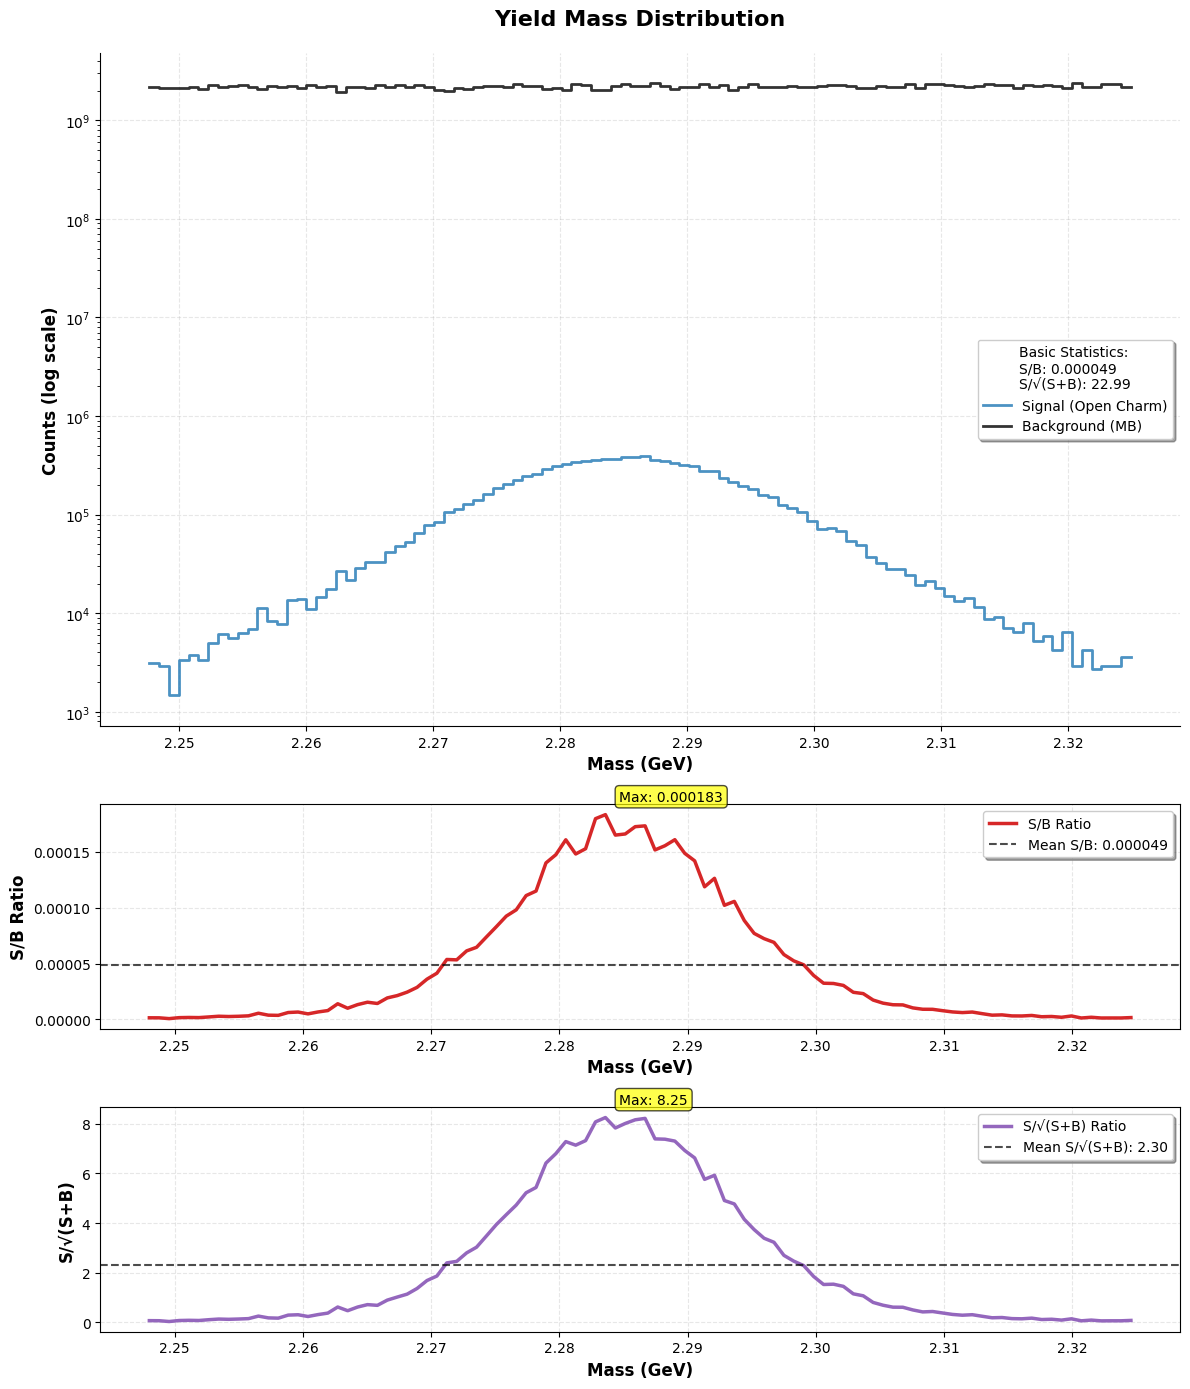


SUMMARY STATISTICS
Total Signal Events: 10787908
Total Background Events: 220145212844
Total Signal Events Unscaled: 51349
Total Background Events Unscaled: 71167
Overall S/B Ratio: 0.000049
Overall S/sqrt(S+B) Significance: 22.99
Maximum S/B Ratio: 0.000183 at 2.284 GeV
Maximum S/sqrt(S+B): 8.25 at 2.284 GeV


In [7]:
from analysis_scripts.estimate_scripts import signal_estimates


sig_mass_distr = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc']
bg_mass_distr = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc']


_ = signal_estimates(
    sig_mass_distr=sig_mass_distr, 
    bg_mass_distr=bg_mass_distr, 
    have_sig_events=CFG.have_sig_events, 
    have_bg_events=CFG.have_bg_events,
    mass_interval=CFG.mass_interval, 
    visualization=True
)

# Selection Path SetUp

In [8]:
topolog_columns = [
    'cosAngle_momentum_Lc_sum_momentum_xy',
    'chi2_Lc_PV_xy', 'dist_Lc_PV_xy', 'dist_Lc_PV_xy_custom',
    'chi2_p_PV_xy', 'dist_p_PV_xy', 'dist_p_PV_xy_custom', 'chi2_K_PV_xy',
    'dist_K_PV_xy', 'dist_K_PV_xy_custom', 'chi2_pip_PV_xy',
    'dist_pip_PV_xy', 'dist_pip_PV_xy_custom', 'chi2_p_Lc_xy',
    'dist_p_Lc_xy', 'dist_p_Lc_xy_custom', 'chi2_K_Lc_xy', 'dist_K_Lc_xy',
    'dist_K_Lc_xy_custom', 'chi2_pip_Lc_xy', 'dist_pip_Lc_xy',
    'dist_pip_Lc_xy_custom', 'chi2_Lc', 'chi2_K_pip_xy', 'dist_K_pip_xy',
    'dist_K_pip_xy_custom', 'chi2_p_K_xy', 'dist_p_K_xy',
    'dist_p_K_xy_custom', 'chi2_p_pip_xy', 'dist_p_pip_xy',
    'dist_p_pip_xy_custom'
]

phys_columns = [
    'P_p', 'P_pip', 'P_K', 'P_Lc', 'eta_p', 'eta_pip',
    'eta_K', 'eta_Lc', 'Pt_Lc', 'Pt_p', 'Pt_K', 'Pt_pip',
    'xF','OA_p', 'OA_K', 'OA_pip', 'ptOverE',
    'lengthXY_Lc', 'dlengthXY_Lc', 'l_over_dl_XY', 'ctau_Lc', 
]

other_columns = [
    'mass_Lc', 'id', 'phi_angle', 'multiplicity',
    'cosAngle_r_Lc_momentum_Lc_xy', 'cosAngle_r_Lc_sum_momentum_xy', 
    'cosAngle_r_Lc_momentum_Lc_xy_left',
    'cosAngle_r_Lc_momentum_Lc_xy_right',
    'cosAngle_r_Lc_sum_momentum_xy_left',
    'cosAngle_r_Lc_sum_momentum_xy_right',
    'Lc_diff_x', 'Lc_diff_y', 'Lc_diff_z',
    'kf_pv_size_before_re_fit', 'kf_pv_size_after_re_fit',
    'PV_diff_x', 'PV_diff_y', 'PV_diff_z', 'PV_diff_ES_x', 'PV_diff_ES_y',
    'PV_diff_ES_z', 'true_decay', 'tag'
]

The selection path is created by a greedy algorithm. 

Starting from all selected features, it finds the feature with the best AUC score at each iteration, applies the corresponding cut for that feature, and then proceeds to the next iteration with the selected feature removed.

In [9]:
from analysis_scripts.selection_scripts import create_best_selection_path


search_columns = [
    'cosAngle_momentum_Lc_sum_momentum_xy',
    'chi2_Lc_PV_xy', 'dist_Lc_PV_xy', 'dist_Lc_PV_xy_custom',
    'chi2_p_PV_xy', 'dist_p_PV_xy', 'dist_p_PV_xy_custom', 'chi2_K_PV_xy',
    'dist_K_PV_xy', 'dist_K_PV_xy_custom', 'chi2_pip_PV_xy',
    'dist_pip_PV_xy', 'dist_pip_PV_xy_custom', 'chi2_p_Lc_xy',
    'dist_p_Lc_xy', 'dist_p_Lc_xy_custom', 'chi2_K_Lc_xy', 'dist_K_Lc_xy',
    'dist_K_Lc_xy_custom', 'chi2_pip_Lc_xy', 'dist_pip_Lc_xy',
    'dist_pip_Lc_xy_custom', 'chi2_Lc', 'chi2_K_pip_xy', 'dist_K_pip_xy',
    'dist_K_pip_xy_custom', 'chi2_p_K_xy', 'dist_p_K_xy',
    'dist_p_K_xy_custom', 'chi2_p_pip_xy', 'dist_p_pip_xy',
    'dist_p_pip_xy_custom',
    
    'P_Lc', 'Pt_Lc', 'OA_p', 'OA_K', 'OA_pip',
    'lengthXY_Lc', 'dlengthXY_Lc', 'l_over_dl_XY', 'ctau_Lc'
]

result_df = create_best_selection_path(
    df=proc_df,
    features=search_columns,
    n_features_to_use=None,
    metric_type='tpr_fpr',
    have_sig_events=CFG.have_sig_events,
    have_bg_events=CFG.have_bg_events, 
    mass_interval=CFG.mass_interval,
    direction_restrictions={
        'lengthXY_Lc': 'right',
        'dlengthXY_Lc': 'right',
        'l_over_dl_XY': 'right',
        'ctau_Lc': 'right',
        'P_Lc': 'right',
        'Pt_Lc': 'right',
        'cosAngle_momentum_Lc_sum_momentum_xy': 'right',
        'chi2_Lc_PV_xy': 'left',
        'dist_Lc_PV_xy': 'left',
        'dist_Lc_PV_xy_custom': 'left',
        'chi2_p_Lc_xy': 'left',
        'dist_p_Lc_xy': 'left',
        'dist_p_Lc_xy_custom': 'left', 
        'chi2_K_Lc_xy': 'left',
        'dist_K_Lc_xy': 'left',
        'dist_K_Lc_xy_custom': 'left',
        'chi2_pip_Lc_xy': 'left',
        'dist_pip_Lc_xy': 'left',
        'dist_pip_Lc_xy_custom': 'left',
        'chi2_K_pip_xy': 'left',
        'dist_K_pip_xy': 'left',
        'dist_K_pip_xy_custom': 'left',
        'chi2_p_K_xy': 'left',
        'dist_p_K_xy': 'left',
        'dist_p_K_xy_custom': 'left',
        'chi2_p_pip_xy': 'left',
        'dist_p_pip_xy': 'left',
        'dist_p_pip_xy_custom': 'left'
    }
)

Selection Progress: 1/41
Remaining features: 41
Remaining events - Signal: 51349, Background: 71167
****************************************
Progress: 1/41
Process feature: cosAngle_momentum_Lc_sum_momentum_xy
Direction restriction encounter. Skip direction: left
Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
AUC value: 0.6431, direction: right
****************************************
Progress: 2/41
Process feature: chi2_Lc_PV_xy
Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
AUC value: 0.5057, direction: left
Direction restriction encounter. Skip direction: right
****************************************
Progress: 3/41
Process feature: dist_Lc_PV_xy
Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point 

In [10]:
result_df

,selected_feature,cut_point,select_direction,signal_efficiency,background_efficiency,ratio,overall_s_sqrt_s_b,total_sig_unscaled,total_bg_unscaled
0,Pt_Lc,1.452819,right,0.757795,0.179184,0.000207,41.156588,38912,12752
1,dist_p_K_xy_custom,0.009448,left,0.695261,0.441891,0.000326,43.043114,27054,5635
2,P_Lc,2.394410,right,0.713055,0.423780,0.000549,47.142046,19291,2388
3,l_over_dl_XY,0.414782,right,0.517495,0.275544,0.001030,46.463770,9983,658
4,dist_Lc_PV_xy_custom,0.001588,left,0.755184,0.525836,0.001480,48.377625,7539,346
5,OA_pip,1.376027,right,0.760711,0.569364,0.001977,48.759737,5735,197
6,lengthXY_Lc,0.009487,right,0.546469,0.360406,0.002998,44.361862,3134,71
7,dist_p_Lc_xy_custom,0.002739,left,0.549138,0.323944,0.005082,42.756897,1721,23
8,cosAngle_momentum_Lc_sum_momentum_xy,1.000000,right,0.586287,0.173913,0.017132,59.753381,1009,4
9,dist_K_Lc_xy_custom,0.004706,left,0.818632,0.250000,0.056099,96.010271,826,1


# Selection Var 1

In [30]:
total_sig_efficiency = 1
total_bg_suppression = 1

cut_based_selection_mask = np.ones(proc_df.shape[0], dtype=bool)

### Cut 1: Pt_Lc

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 1.452818813076517
Signal efficiency: 0.7577946990204288
Background Suppression: 0.17918417243947335


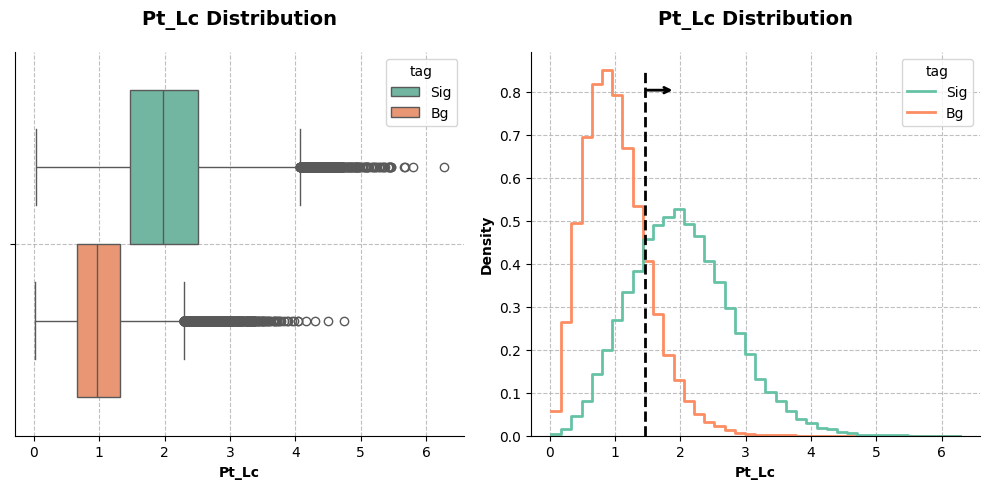

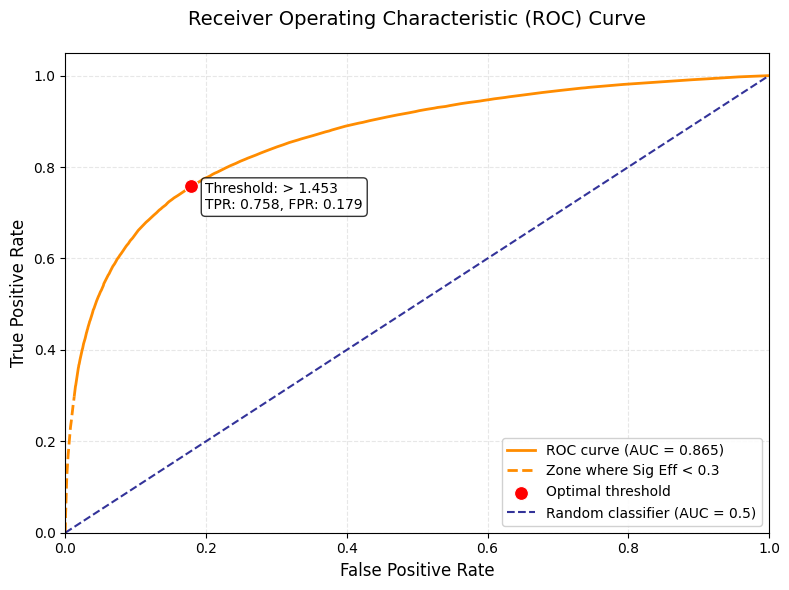

In [ ]:
from analysis_scripts.draw_scripts import draw_feature_distribution
from analysis_scripts.draw_scripts import draw_roc
from analysis_scripts.selection_scripts import find_optimal_cut_point


feature = 'Pt_Lc'
select_direction = 'right'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric, thresholds, tpr, fpr, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    mass_interval=CFG.mass_interval
)

if bounds is not None:
    bounds_mask = (proc_df[feature] >= bounds[0]) & (proc_df[feature] <= bounds[1])
    proc_df = proc_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_metric = metric[min_sig_sel_mask][best_arg]
best_tpr = tpr[min_sig_sel_mask][best_arg]
best_fpr = fpr[min_sig_sel_mask][best_arg]

#--------------------------------------------------
# # Manual cut
# best_cut_x = 2.075
# 
# # find index by value
# val = 2.075
# arr = thresholds[min_sig_sel_mask]
# 
# diff = abs(arr - val)
# index = np.argmin(diff)
#     
# best_tpr = tpr[min_sig_sel_mask][index]
# best_fpr = fpr[min_sig_sel_mask][index]
#--------------------------------------------------

draw_feature_distribution(
    df=proc_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

_ = draw_roc(
        tpr=tpr,
        fpr=fpr,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

plt.savefig(f'../plots/{feature}_roc_auc.pdf')

# Create mask
if select_direction == 'right':
    mask = proc_df[feature] > best_cut_x
    general_mask = proc_df_copy[feature] > best_cut_x
else:
    mask = proc_df[feature] < best_cut_x
    general_mask = proc_df_copy[feature] < best_cut_x

proc_df = proc_df[mask]
cut_based_selection_mask &= general_mask

print(f'Cut point: {best_cut_x}')

sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

### Cut 2: dist_p_K_xy_custom

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 0.009447896804871111
Signal efficiency: 0.6952611019736842
Background Suppression: 0.44189146800501883


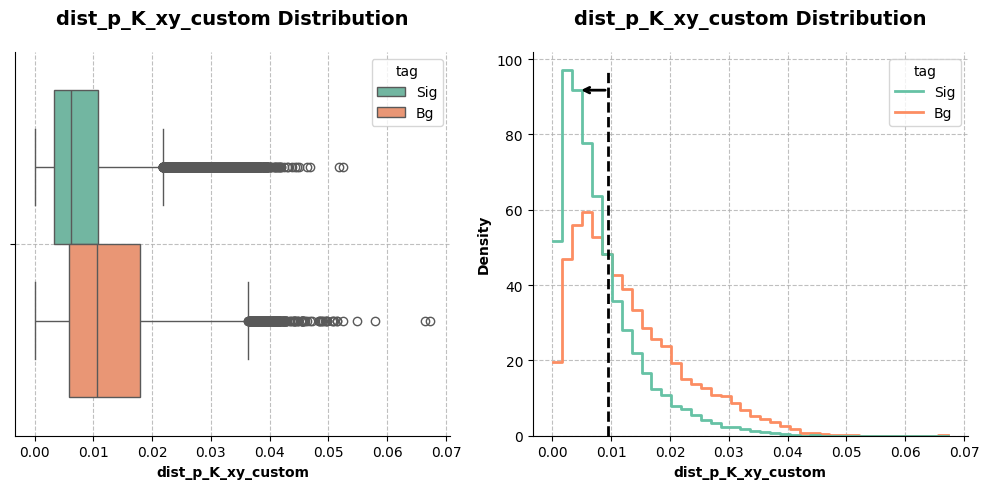

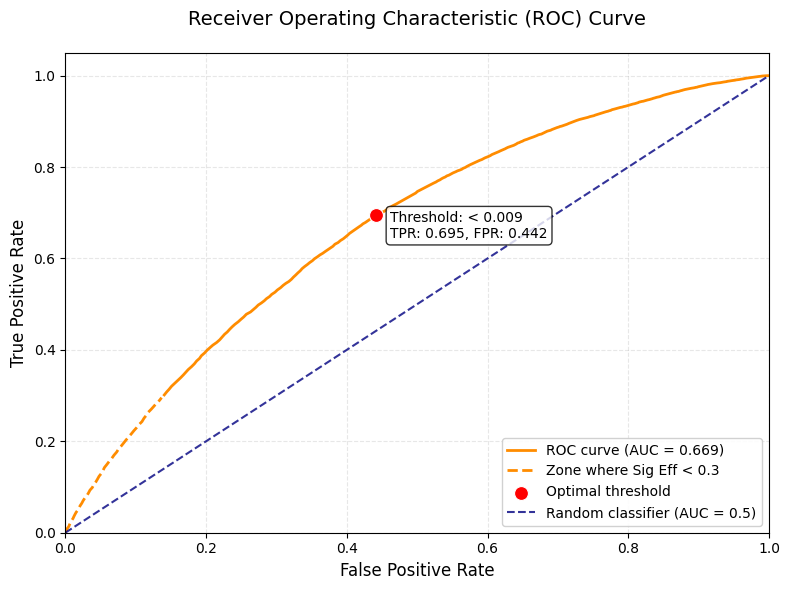

In [ ]:
from analysis_scripts.draw_scripts import draw_feature_distribution
from analysis_scripts.draw_scripts import draw_roc
from analysis_scripts.selection_scripts import find_optimal_cut_point


feature = 'dist_p_K_xy_custom'
select_direction = 'left'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric, thresholds, tpr, fpr, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    mass_interval=CFG.mass_interval
)

if bounds is not None:
    bounds_mask = (proc_df[feature] >= bounds[0]) & (proc_df[feature] <= bounds[1])
    proc_df = proc_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_metric = metric[min_sig_sel_mask][best_arg]
best_tpr = tpr[min_sig_sel_mask][best_arg]
best_fpr = fpr[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=proc_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

_ = draw_roc(
        tpr=tpr,
        fpr=fpr,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

plt.savefig(f'../plots/{feature}_roc_auc.pdf')

# Create mask
if select_direction == 'right':
    mask = proc_df[feature] > best_cut_x
    general_mask = proc_df_copy[feature] > best_cut_x
else:
    mask = proc_df[feature] < best_cut_x
    general_mask = proc_df_copy[feature] < best_cut_x

proc_df = proc_df[mask]
cut_based_selection_mask &= general_mask

print(f'Cut point: {best_cut_x}')

sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

### Cut 3: P_Lc

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 2.3944097426799207
Signal efficiency: 0.7130553707400015
Background Suppression: 0.4237799467613132


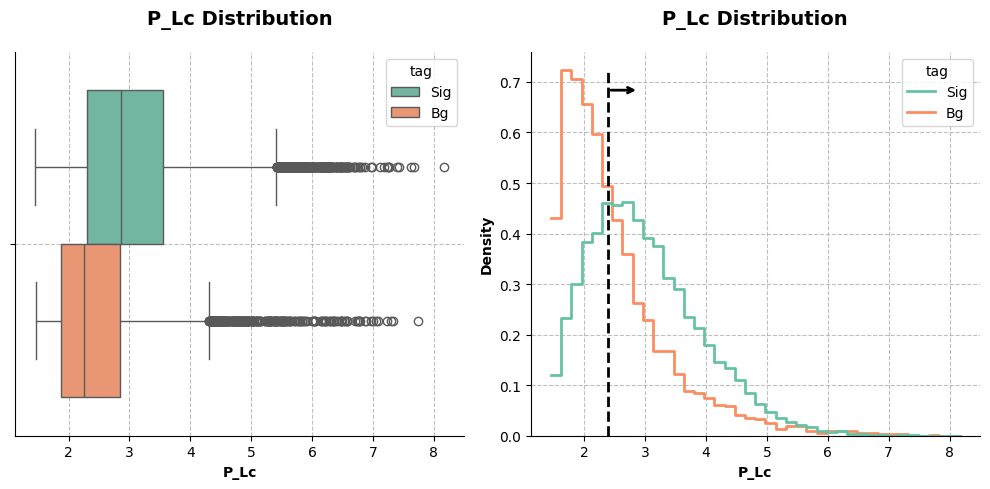

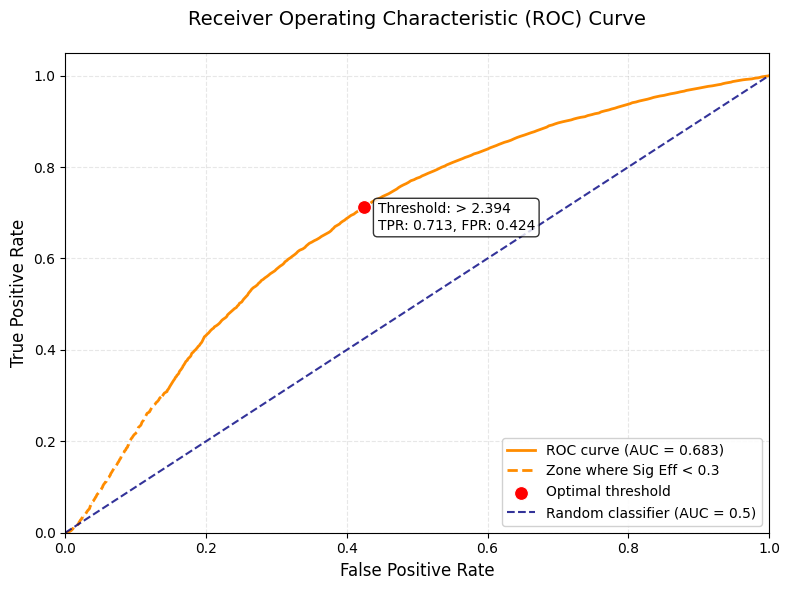

In [33]:
from analysis_scripts.draw_scripts import draw_feature_distribution
from analysis_scripts.draw_scripts import draw_roc
from analysis_scripts.selection_scripts import find_optimal_cut_point


feature = 'P_Lc'
select_direction = 'right'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric, thresholds, tpr, fpr, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    mass_interval=CFG.mass_interval
)

if bounds is not None:
    bounds_mask = (proc_df[feature] >= bounds[0]) & (proc_df[feature] <= bounds[1])
    proc_df = proc_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_metric = metric[min_sig_sel_mask][best_arg]
best_tpr = tpr[min_sig_sel_mask][best_arg]
best_fpr = fpr[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=proc_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

_ = draw_roc(
        tpr=tpr,
        fpr=fpr,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

plt.savefig(f'../plots/{feature}_roc_auc.pdf')

# Create mask
if select_direction == 'right':
    mask = proc_df[feature] > best_cut_x
    general_mask = proc_df_copy[feature] > best_cut_x
else:
    mask = proc_df[feature] < best_cut_x
    general_mask = proc_df_copy[feature] < best_cut_x

proc_df = proc_df[mask]
cut_based_selection_mask &= general_mask

print(f'Cut point: {best_cut_x}')

sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

### Cut 4: l_over_dl_XY

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 0.4147824145890855
Signal efficiency: 0.517495205017884
Background Suppression: 0.27554438860971525


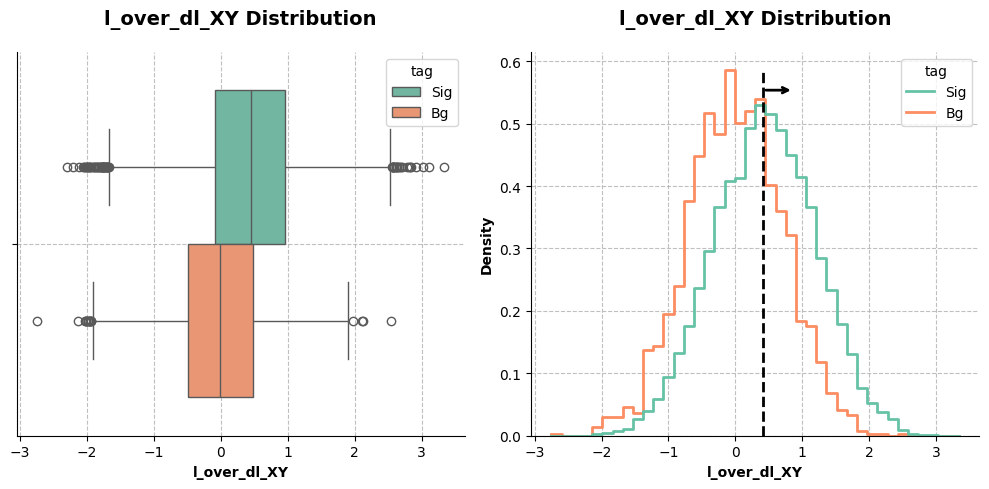

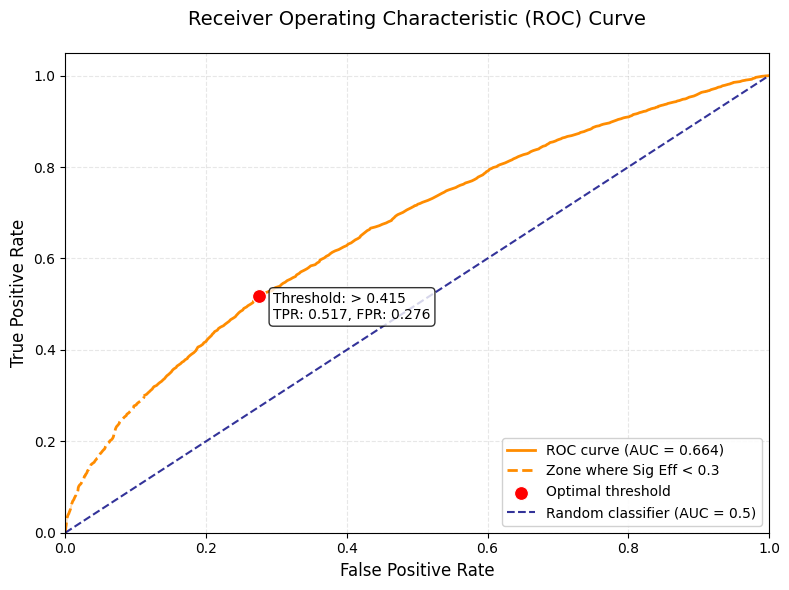

In [34]:
from analysis_scripts.draw_scripts import draw_feature_distribution
from analysis_scripts.draw_scripts import draw_roc
from analysis_scripts.selection_scripts import find_optimal_cut_point


feature = 'l_over_dl_XY'
select_direction = 'right'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric, thresholds, tpr, fpr, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    mass_interval=CFG.mass_interval
)

if bounds is not None:
    bounds_mask = (proc_df[feature] >= bounds[0]) & (proc_df[feature] <= bounds[1])
    proc_df = proc_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_metric = metric[min_sig_sel_mask][best_arg]
best_tpr = tpr[min_sig_sel_mask][best_arg]
best_fpr = fpr[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=proc_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

_ = draw_roc(
        tpr=tpr,
        fpr=fpr,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

plt.savefig(f'../plots/{feature}_roc_auc.pdf')

# Create mask
if select_direction == 'right':
    mask = proc_df[feature] > best_cut_x
    general_mask = proc_df_copy[feature] > best_cut_x
else:
    mask = proc_df[feature] < best_cut_x
    general_mask = proc_df_copy[feature] < best_cut_x

proc_df = proc_df[mask]
cut_based_selection_mask &= general_mask

print(f'Cut point: {best_cut_x}')

sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

### Cut 5: dist_Lc_PV_xy_custom

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 0.0015882111250743636
Signal efficiency: 0.755183812481218
Background Suppression: 0.5258358662613982


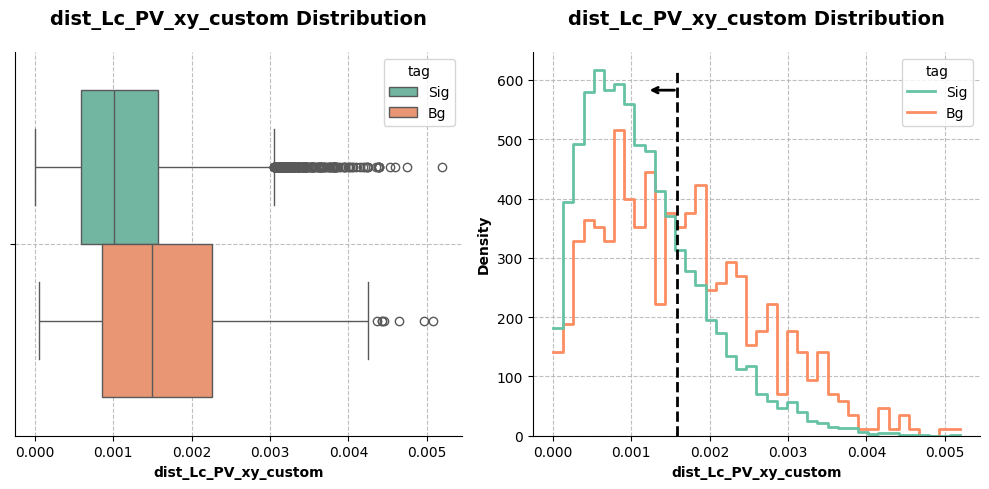

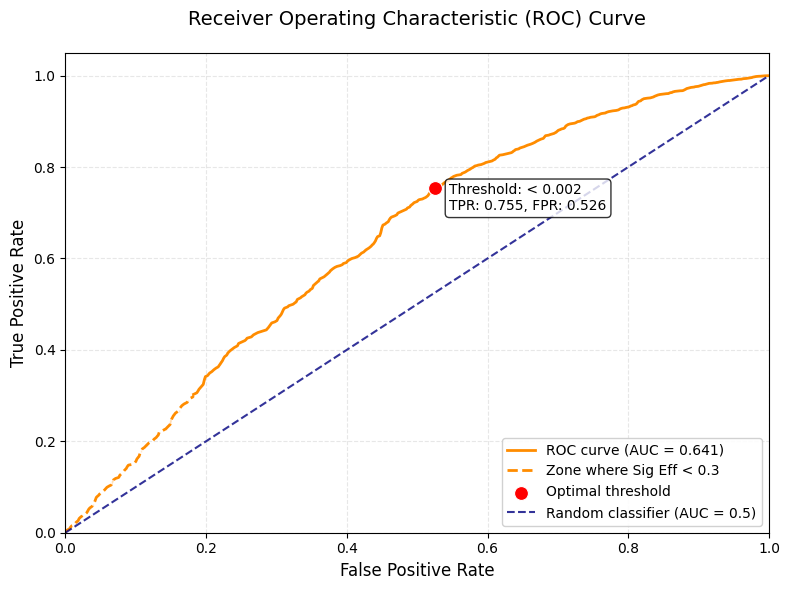

In [35]:
from analysis_scripts.draw_scripts import draw_feature_distribution
from analysis_scripts.draw_scripts import draw_roc
from analysis_scripts.selection_scripts import find_optimal_cut_point


feature = 'dist_Lc_PV_xy_custom'
select_direction = 'left'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric, thresholds, tpr, fpr, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    mass_interval=CFG.mass_interval
)

if bounds is not None:
    bounds_mask = (proc_df[feature] >= bounds[0]) & (proc_df[feature] <= bounds[1])
    proc_df = proc_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_metric = metric[min_sig_sel_mask][best_arg]
best_tpr = tpr[min_sig_sel_mask][best_arg]
best_fpr = fpr[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=proc_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

_ = draw_roc(
        tpr=tpr,
        fpr=fpr,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

plt.savefig(f'../plots/{feature}_roc_auc.pdf')

# Create mask
if select_direction == 'right':
    mask = proc_df[feature] > best_cut_x
    general_mask = proc_df_copy[feature] > best_cut_x
else:
    mask = proc_df[feature] < best_cut_x
    general_mask = proc_df_copy[feature] < best_cut_x

proc_df = proc_df[mask]
cut_based_selection_mask &= general_mask

print(f'Cut point: {best_cut_x}')

sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

### Cut 6: OA_pip

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 1.3760267249444695
Signal efficiency: 0.7607109696246187
Background Suppression: 0.569364161849711


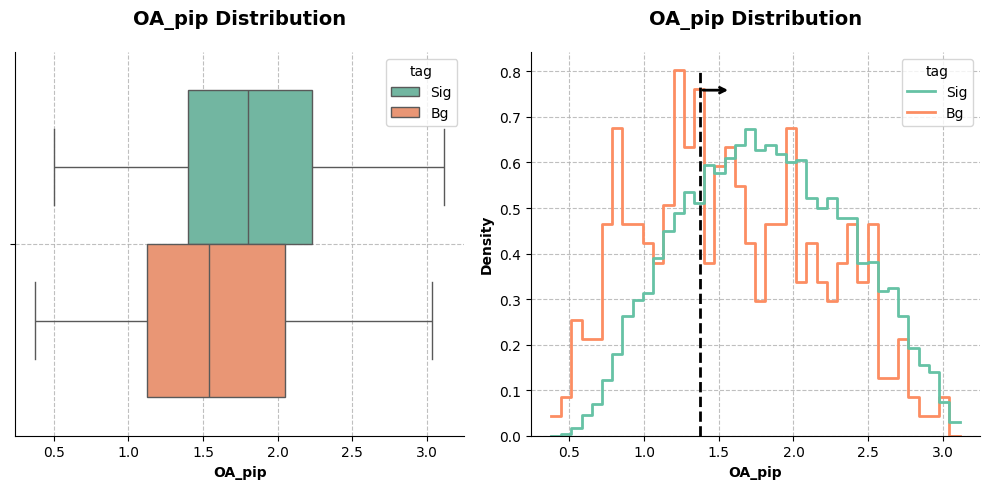

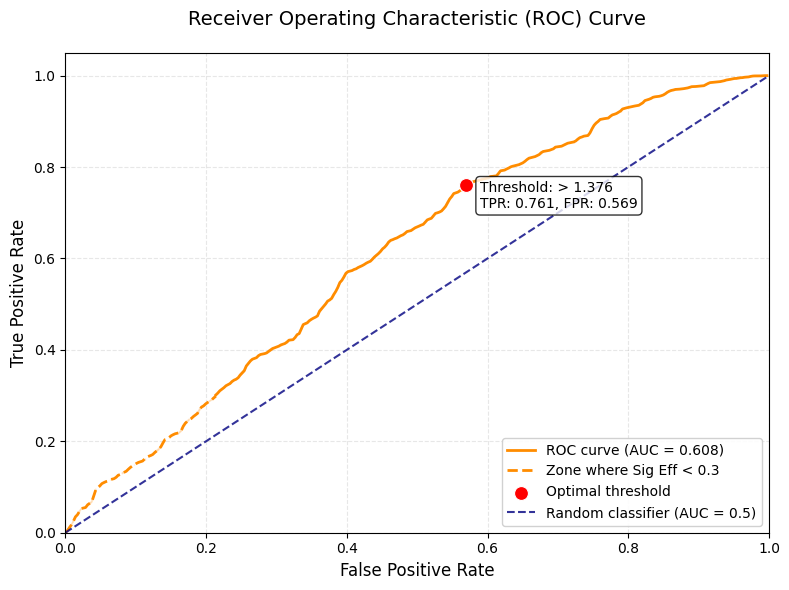

In [36]:
from analysis_scripts.draw_scripts import draw_feature_distribution
from analysis_scripts.draw_scripts import draw_roc
from analysis_scripts.selection_scripts import find_optimal_cut_point


feature = 'OA_pip'
select_direction = 'right'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric, thresholds, tpr, fpr, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    mass_interval=CFG.mass_interval
)

if bounds is not None:
    bounds_mask = (proc_df[feature] >= bounds[0]) & (proc_df[feature] <= bounds[1])
    proc_df = proc_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_metric = metric[min_sig_sel_mask][best_arg]
best_tpr = tpr[min_sig_sel_mask][best_arg]
best_fpr = fpr[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=proc_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

_ = draw_roc(
        tpr=tpr,
        fpr=fpr,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

plt.savefig(f'../plots/{feature}_roc_auc.pdf')

# Create mask
if select_direction == 'right':
    mask = proc_df[feature] > best_cut_x
    general_mask = proc_df_copy[feature] > best_cut_x
else:
    mask = proc_df[feature] < best_cut_x
    general_mask = proc_df_copy[feature] < best_cut_x

proc_df = proc_df[mask]
cut_based_selection_mask &= general_mask

print(f'Cut point: {best_cut_x}')

sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

### Cut 7: lengthXY_Lc

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 0.009487343543032873
Signal efficiency: 0.5464690496948561
Background Suppression: 0.3604060913705584


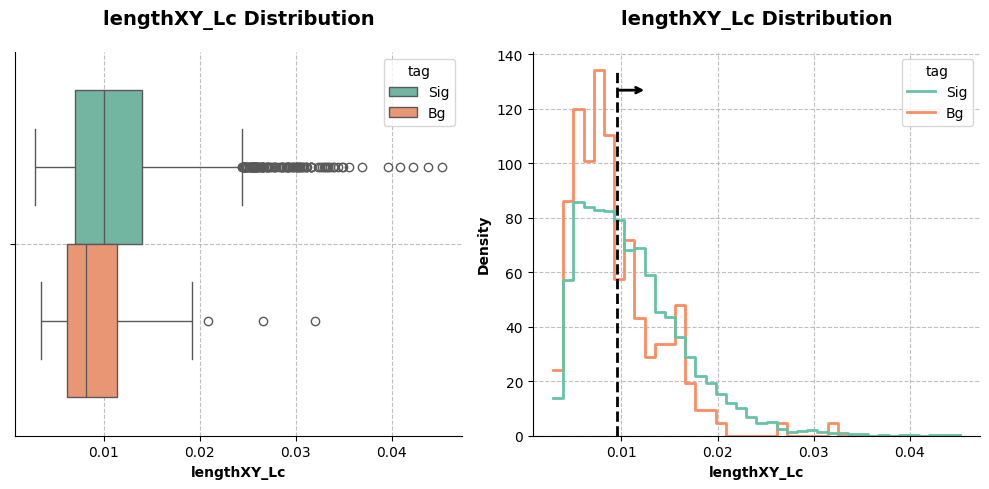

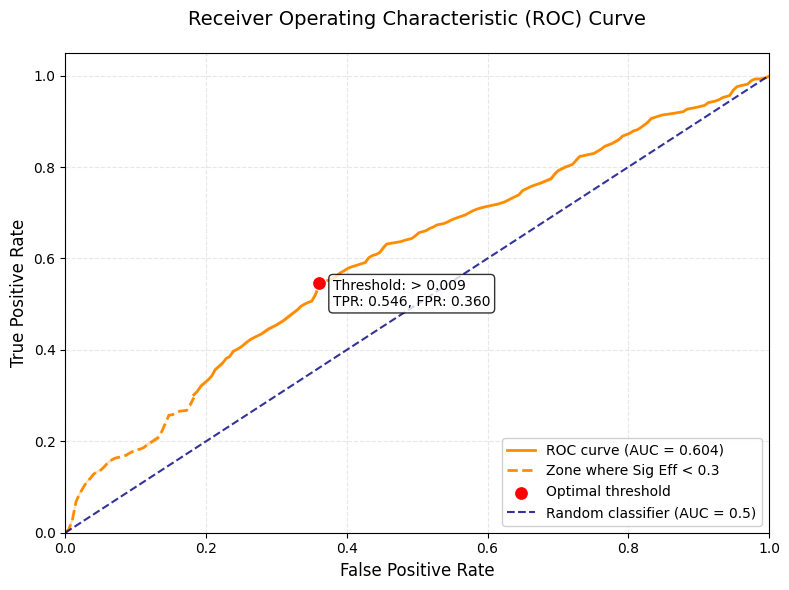

In [37]:
from analysis_scripts.draw_scripts import draw_feature_distribution
from analysis_scripts.draw_scripts import draw_roc
from analysis_scripts.selection_scripts import find_optimal_cut_point


feature = 'lengthXY_Lc'
select_direction = 'right'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric, thresholds, tpr, fpr, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    mass_interval=CFG.mass_interval
)

if bounds is not None:
    bounds_mask = (proc_df[feature] >= bounds[0]) & (proc_df[feature] <= bounds[1])
    proc_df = proc_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_metric = metric[min_sig_sel_mask][best_arg]
best_tpr = tpr[min_sig_sel_mask][best_arg]
best_fpr = fpr[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=proc_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

_ = draw_roc(
        tpr=tpr,
        fpr=fpr,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

plt.savefig(f'../plots/{feature}_roc_auc.pdf')

# Create mask
if select_direction == 'right':
    mask = proc_df[feature] > best_cut_x
    general_mask = proc_df_copy[feature] > best_cut_x
else:
    mask = proc_df[feature] < best_cut_x
    general_mask = proc_df_copy[feature] < best_cut_x

proc_df = proc_df[mask]
cut_based_selection_mask &= general_mask

print(f'Cut point: {best_cut_x}')

sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

### Cut 8: dist_p_Lc_xy_custom

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 0.0027390631115790025
Signal efficiency: 0.5491384811742183
Background Suppression: 0.323943661971831


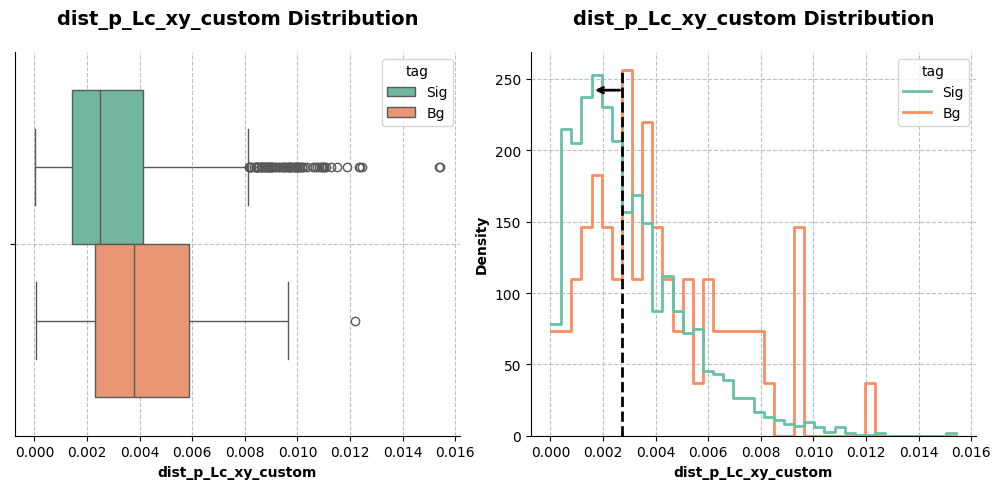

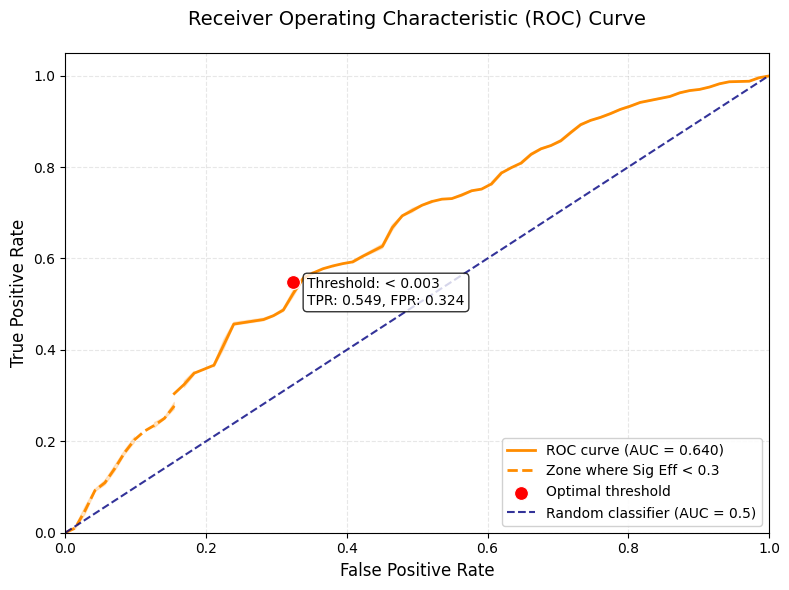

In [38]:
from analysis_scripts.draw_scripts import draw_feature_distribution
from analysis_scripts.draw_scripts import draw_roc
from analysis_scripts.selection_scripts import find_optimal_cut_point


feature = 'dist_p_Lc_xy_custom'
select_direction = 'left'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric, thresholds, tpr, fpr, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    mass_interval=CFG.mass_interval
)

if bounds is not None:
    bounds_mask = (proc_df[feature] >= bounds[0]) & (proc_df[feature] <= bounds[1])
    proc_df = proc_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_metric = metric[min_sig_sel_mask][best_arg]
best_tpr = tpr[min_sig_sel_mask][best_arg]
best_fpr = fpr[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=proc_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

_ = draw_roc(
        tpr=tpr,
        fpr=fpr,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

plt.savefig(f'../plots/{feature}_roc_auc.pdf')

# Create mask
if select_direction == 'right':
    mask = proc_df[feature] > best_cut_x
    general_mask = proc_df_copy[feature] > best_cut_x
else:
    mask = proc_df[feature] < best_cut_x
    general_mask = proc_df_copy[feature] < best_cut_x

proc_df = proc_df[mask]
cut_based_selection_mask &= general_mask

print(f'Cut point: {best_cut_x}')

sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

### Cut 9: cosAngle_momentum_Lc_sum_momentum_xy

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 0.9999999607945337
Signal efficiency: 0.5862870424171993
Background Suppression: 0.17391304347826086


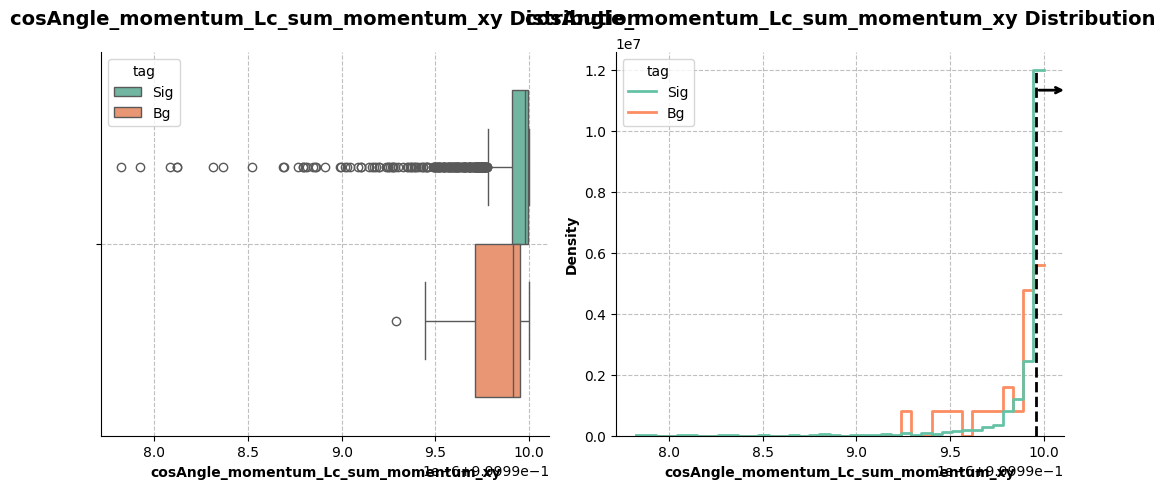

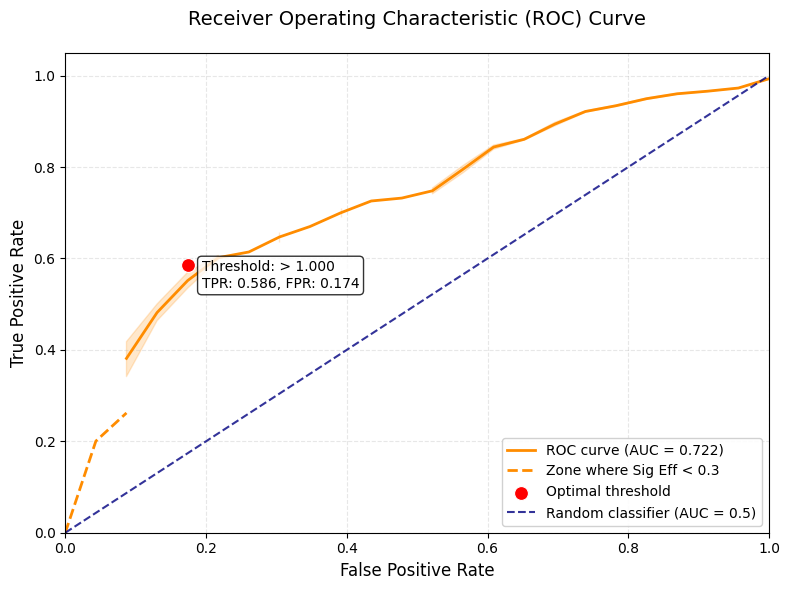

In [39]:
from analysis_scripts.draw_scripts import draw_feature_distribution
from analysis_scripts.draw_scripts import draw_roc
from analysis_scripts.selection_scripts import find_optimal_cut_point


feature = 'cosAngle_momentum_Lc_sum_momentum_xy'
select_direction = 'right'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric, thresholds, tpr, fpr, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    mass_interval=CFG.mass_interval
)

if bounds is not None:
    bounds_mask = (proc_df[feature] >= bounds[0]) & (proc_df[feature] <= bounds[1])
    proc_df = proc_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_metric = metric[min_sig_sel_mask][best_arg]
best_tpr = tpr[min_sig_sel_mask][best_arg]
best_fpr = fpr[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=proc_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

_ = draw_roc(
        tpr=tpr,
        fpr=fpr,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

plt.savefig(f'../plots/{feature}_roc_auc.pdf')

# Create mask
if select_direction == 'right':
    mask = proc_df[feature] > best_cut_x
    general_mask = proc_df_copy[feature] > best_cut_x
else:
    mask = proc_df[feature] < best_cut_x
    general_mask = proc_df_copy[feature] < best_cut_x

proc_df = proc_df[mask]
cut_based_selection_mask &= general_mask

print(f'Cut point: {best_cut_x}')

sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

### Cut 10: dist_K_Lc_xy_custom

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 0.004705785367889191
Signal efficiency: 0.8186323092170465
Background Suppression: 0.25


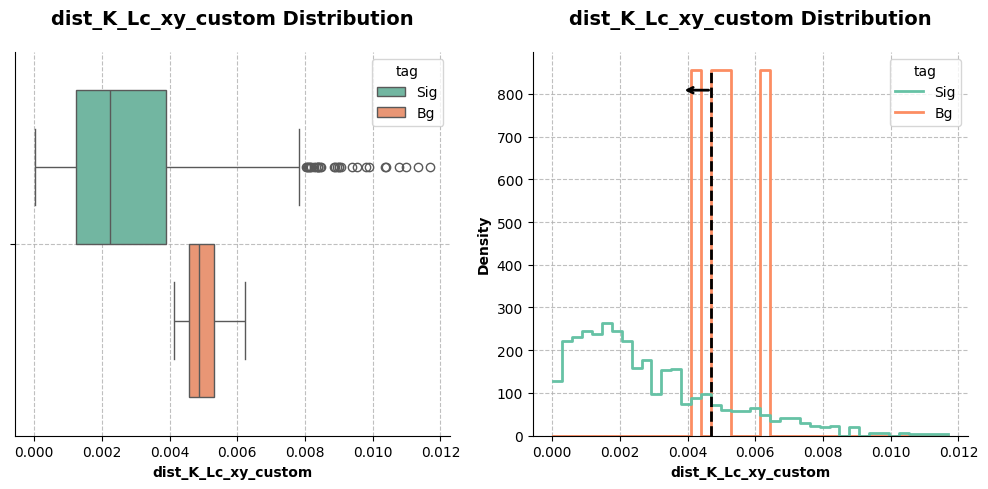

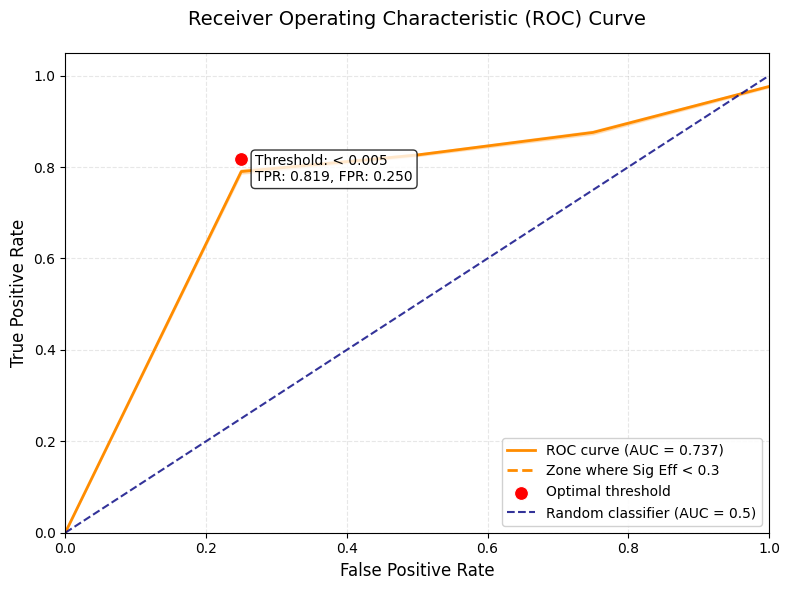

In [40]:
from analysis_scripts.draw_scripts import draw_feature_distribution
from analysis_scripts.draw_scripts import draw_roc
from analysis_scripts.selection_scripts import find_optimal_cut_point


feature = 'dist_K_Lc_xy_custom'
select_direction = 'left'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric, thresholds, tpr, fpr, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    mass_interval=CFG.mass_interval
)

if bounds is not None:
    bounds_mask = (proc_df[feature] >= bounds[0]) & (proc_df[feature] <= bounds[1])
    proc_df = proc_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_metric = metric[min_sig_sel_mask][best_arg]
best_tpr = tpr[min_sig_sel_mask][best_arg]
best_fpr = fpr[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=proc_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

_ = draw_roc(
        tpr=tpr,
        fpr=fpr,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

plt.savefig(f'../plots/{feature}_roc_auc.pdf')

# Create mask
if select_direction == 'right':
    mask = proc_df[feature] > best_cut_x
    general_mask = proc_df_copy[feature] > best_cut_x
else:
    mask = proc_df[feature] < best_cut_x
    general_mask = proc_df_copy[feature] < best_cut_x

proc_df = proc_df[mask]
cut_based_selection_mask &= general_mask

print(f'Cut point: {best_cut_x}')

sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

# Data Stats After Selection

In [41]:
print(f'Total signal efficiency: {total_sig_efficiency}')
print(f'Total background suppression: {total_bg_suppression}')

print(f'\nTotal signal efficiency (include presel): {total_sig_efficiency * sig_eff_presel}')
print(f'Total background suppression (include presel): {total_bg_suppression * bg_eff_presel}')

Total signal efficiency: 0.016085999727355936
Total background suppression: 1.4051456433459328e-05

Total signal efficiency (include presel): 0.008051231565506417
Total background suppression (include presel): 2.1310147892426374e-06


In [ ]:
# This classification doesn't include preselection

# Try to perform weighted score like:

# feature_1 * 1 / efficiency_1 + ...


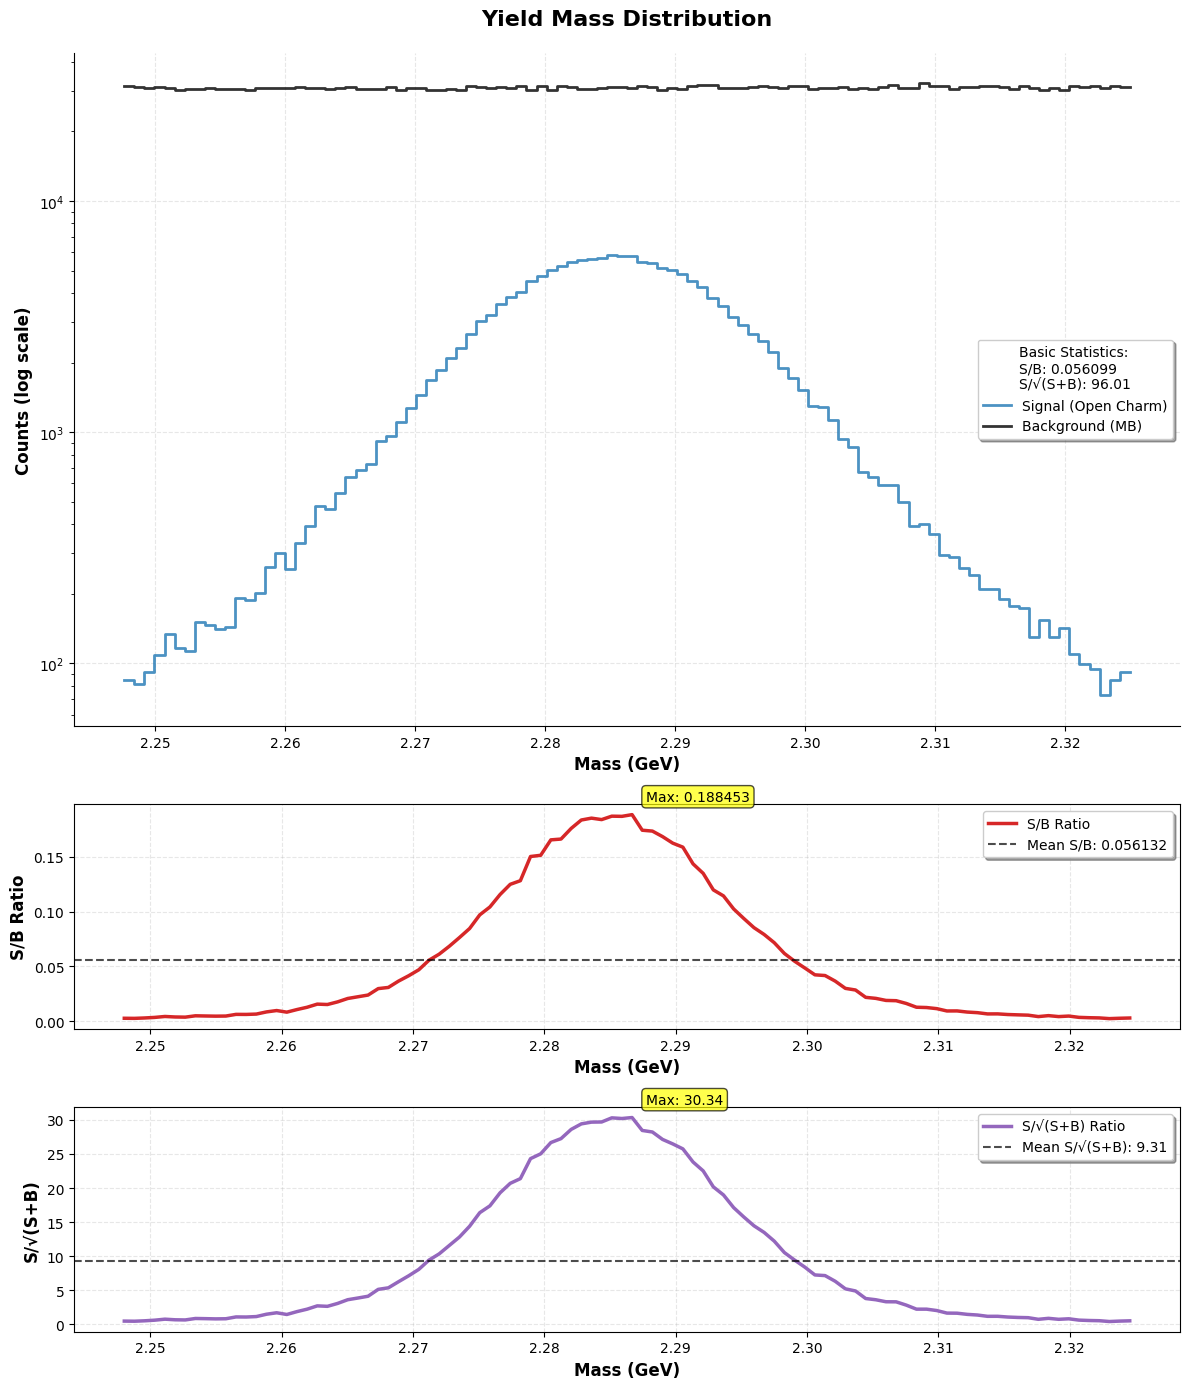


SUMMARY STATISTICS
Total Signal Events: 173534
Total Background Events: 3093361
Total Signal Events Unscaled: 102593
Total Background Events Unscaled: 469260
Overall S/B Ratio: 0.056099
Overall S/sqrt(S+B) Significance: 96.01
Maximum S/B Ratio: 0.188453 at 2.287 GeV
Maximum S/sqrt(S+B): 30.34 at 2.287 GeV


<Figure size 640x480 with 0 Axes>

In [42]:
from analysis_scripts.estimate_scripts import signal_estimates


sig_mass_distr = raw_df.loc[raw_df['tag'] == 'Sig', 'mass_Lc']
bg_mass_distr = raw_df.loc[raw_df['tag'] == 'Bg', 'mass_Lc']

_ = signal_estimates(
    sig_mass_distr=sig_mass_distr, 
    bg_mass_distr=bg_mass_distr, 
    have_sig_events=CFG.have_sig_events / total_sig_efficiency / sig_eff_presel, 
    have_bg_events=CFG.have_bg_events / total_bg_suppression / bg_eff_presel,
    mass_interval=CFG.mass_interval, 
    visualization=True
)

plt.savefig(f'../plots/mass_distr_after_selection.pdf')

# Features After Selection

In [ ]:
# from analysis_scripts.draw_scripts import draw_feature_distribution
# 
# 
# for feature in phys_columns + topolog_columns + other_columns:
#     
#     draw_feature_distribution(
#         df=proc_df,
#         distr_name=feature,
#         tag=None,
#         hue='tag',
#         bins=40,
#         norma=True,
#         cut_point=None,
#         select_direction=None
#     )